# ML-Powered Forest Protection: A Decision Support System Using Satellite Imagery and Machine Learning for Real-Time Deforestation Detection and Wildfire Risk Prediction

# Project Overview
This project uses satellite data to monitor forests and support decision-making. MODIS satellite data from NASA’s Terra and Aqua satellites is used to study vegetation and wildfire patterns. The satellite data is processed into GeoTIFF format and analyzed using geospatial and machine learning techniques.

# Key Beneficiaries
* Forest Departments
* Disaster Management
* Environmental NGOs
* Governments & Policy Makers
  
# The current project flow
MODIS Satellite (Terra & Aqua) → MODIS Products (MOD13Q1, MCD64A1) → Geospatial Processing (GeoTIFF) →Data Preprocessing (Clipping, Scaling, Cleaning) → Feature Engineering (NDVI, EVI) → Training Dataset Preparation (Balanced Burn / Non-burn Samples) → Machine Learning Models (Random Forest, XGBoost) → Hyperparameter Tuning & Validation → Wildfire Prediction for 2023 → Model Evaluation (Accuracy, AUC, Error Maps) → Visualization & Decision Support System
 
# Future Scope

MODIS + Sentinel Satellite Data → Data Fusion Engine → Advanced ML / Deep Learning Models → Improved Wildfire Prediction → Early Warning Alerts → Decision Support for Authorities

# Install Libraries 
* Sentinelhub (Future scope)
* XG Boost - XGBoost helps the project by acting like a smart learner that improves step by step. It looks at past mistakes, learns from them, and makes better predictions each time, giving more accurate and reliable results than simpler models.
* Earth Engine API (earthengine-api) - , the Earth Engine API is used to directly access MODIS satellite data (such as fire, land surface temperature, or vegetation indices) from Google’s cloud and process it efficiently. It helps the project extract meaningful features like fire occurrence, temperature, or vegetation health over time without downloading large files, making the analysis faster and scalable. These processed MODIS features are then used as inputs for machine learning models to improve prediction accuracy.
* Rasterio -  It helps the project open satellite image files (GeoTIFFs), access pixel values, crop areas of interest, and prepare clean raster data. This allows MODIS images to be converted into usable numerical inputs that can be analyzed or fed into machine learning models.
* Folium - Ithelps the project visualize MODIS results on real maps. It allows you to display fire locations, affected areas, or model predictions on an interactive map where users can zoom, pan, and click. This makes the results easy to understand and visually communicate, even for non-technical users.
* SHAP - SHAP shows why the model gave a particular prediction by indicating which features pushed the prediction up or down. In your project, it helps explain XGBoost results by identifying the most important MODIS-derived features, making the model’s predictions transparent, trustworthy, and easier to understand for both technical and non-technical users.
* geemap - geemap allows the project to visualize and explore MODIS satellite data directly from Earth Engine on interactive maps. It helps display layers like fire detections, vegetation indices, or temperature over specific regions, making satellite analysis and results easy to understand without downloading large datasets.


In [201]:
!pip install sentinelhub
!pip install xgboost
!pip install earthengine-api
!pip install rasterio
!pip install folium
!pip install shap
!pip install geemap

# Add ML Libraries 

In [202]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning - Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# XGBoost
import xgboost as xgb

# Explainability
import shap
# Geospatial & Raster

import rasterio
from rasterio.plot import show
import geemap
import ee
import folium
from sentinelhub import BBox, CRS

# Initialize Google Earth Engin APIs

In [203]:
class APIManager:
    def __init__(self):
        # Track Earth Engine initialization status
        self.ee_initialized = False

    def initialize_earth_engine(self):
        """
        Initialize Google Earth Engine for accessing MODIS data
        """
        try:
            ee.Initialize()
            self.ee_initialized = True
            print("Earth Engine initialized successfully for MODIS data.")
        except Exception as e:
            print("Error initializing Earth Engine:", e)

In [204]:
import ee
ee.Authenticate()
ee.Initialize() # It connects Python environment to the Earth Engine servers so you can start working with datasets (like MODIS, Sentinel, Landsat, etc.).
api_manager = APIManager() 
api_manager.initialize_earth_engine() 

Earth Engine initialized successfully for MODIS data.


In [205]:
# Initialize APIs
api_manager = APIManager()
api_manager.initialize_earth_engine()

Earth Engine initialized successfully for MODIS data.


# Study Area 
* StudyArea is something where are we studying or applying the ML model for getting the information. Here it act as a reusable object that store and manage all geographic information needed for the satlite data execution, ML analyis and Visualoization.
Here we initialiyze a study area with geographic boundaries using coordinates.
The expected format is [min_lon, min_lat, max_lon, max_lat]. We convert the bounding box into Google earth engine geometry which is used for Clipping satellite images, Filtering image collections, Computing vegetation indices (NDVI, EVI, etc.)


In [206]:
class StudyArea:
    def __init__(self, name, bounds, crs='EPSG:4326'):
        self.name = name
        self.bounds = bounds
        self.crs = crs
        self.ee_geometry = ee.Geometry.Rectangle(bounds)
        self.bbox = BBox(bbox=bounds, crs=CRS.WGS84)

    def get_folium_map(self, zoom_start=10):
        center_lat = (self.bounds[1] + self.bounds[3]) / 2
        center_lon = (self.bounds[0] + self.bounds[2]) / 2

        m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom_start)

        folium.Rectangle(
            bounds=[[self.bounds[1], self.bounds[0]], [self.bounds[3], self.bounds[2]]],
            color="blue",
            fill=False,
            weight=1,
            popup=self.name  # optional: label on click
        ).add_to(m)

        return m

# Defining the boundaries 

In [207]:
areas = {
    "Berlin": StudyArea("Berlin", [12.8, 52.1, 13.9, 52.9]),
    "Amazon": StudyArea("Amazon", [-63.5, -10.5, -62.0, -9.0]),
    "Canada_Fire": StudyArea("Canada_Fire", [-122.5, 54.5, -121.0, 55.5]),
    "Australia_Fire": StudyArea("Australia_Fire", [146.0, -38.5, 147.5, -37.0]),
    "British_Colombia": StudyArea("BC_Large", [-128.0, 49.0, -114.0, 60.0])
    
}

## Selecting one region from the created list 

In [208]:
choice = "British_Colombia"  # or any key
study_area = areas[choice]
aoi = study_area.ee_geometry

* This code block defines a geospatial data processing pipeline that prepares satellite-derived features and labels for a machine learning–based forest protection system. It integrates Google Earth Engine, MODIS satellite products, and interactive spatial visualization to support wildfire detection and risk prediction within a defined geographic study area.

In [209]:
class MODISProcessor:
    def __init__(self, study_area):
        self.study_area = study_area  # expects .ee_geometry

    def get_modis_burn_label(self, start_date, end_date):
        """
        Returns an ee.Image with band 'BURN_LABEL' (0/1)
        using MODIS Burned Area product MCD64A1.
        """
        ba = (ee.ImageCollection("MODIS/061/MCD64A1")
              .filterDate(start_date, end_date)
              .filterBounds(self.study_area.ee_geometry)
              .select("BurnDate"))

        burn_label = ba.max().gt(0).rename("BURN_LABEL").clip(self.study_area.ee_geometry)
        return burn_label

    def get_modis_vegetation_indices(self, start_date, end_date):
        """
        Returns an ee.Image with NDVI/EVI scaled to [~ -1..1]
        from MOD13Q1 (16-day, 250m).
        """
        col = (ee.ImageCollection("MODIS/061/MOD13Q1")
               .filterDate(start_date, end_date)
               .filterBounds(self.study_area.ee_geometry)
               .select(["NDVI", "EVI"]))

        # scale factor 0.0001
        def scale(img):
            return img.multiply(0.0001).copyProperties(img, img.propertyNames())

        img = col.map(scale).median().clip(self.study_area.ee_geometry)
        return img


This code block processes MODIS burned area satellite imagery to identify wildfire occurrences within a defined area of interest during 2023. It aggregates burn date information to create a binary wildfire label map, handles missing data, and spatially clips the results to the study area. A frequency histogram is then computed to quantify the number of burned and unburned pixels, providing essential insights into wildfire distribution and class balance for supervised machine learning model development.

In [210]:
start, end = "2023-01-01", "2023-12-31"

burn_date = (ee.ImageCollection("MODIS/061/MCD64A1") # Burned area dataset and it provides global burned area detection, pixel level burn dates...
             .filterDate(start, end) 
             .filterBounds(aoi) # To limit the analyisis with in the study area 
             .select("BurnDate") # 0 -> No fire and 0> Fire occured 
             .max()  # Finds the maximum burn date across the year
             .unmask(0) # Ensures every pixel has a value
             .clip(aoi)) # Removes pixels outside the study area.

burn_label = burn_date.gt(0).rename("BURN_LABEL") # Converts the burned dates into 1 -> Burned pixel 0-> Unburned Pixel

hist = burn_label.reduceRegion(
    ee.Reducer.frequencyHistogram(),
    aoi,
    500,
    maxPixels=1e13
).get("BURN_LABEL")

print("Burn histogram:", hist.getInfo())

Burn histogram: {'0': 7282331.474509844, '1': 255388.21960784314}


- Here we find howmany pixels are labelsed as burned (1) and unbound (0) in the StudyArea 

In [211]:
hist = burn_label.reduceRegion(
    ee.Reducer.frequencyHistogram(), # Counts how often each pixel value occurs
    aoi, # Area of of Study interest
    500, # Spatial Resolution
    maxPixels=1e13 # It allows to process the large regions without error
).get("BURN_LABEL")

print("Burn label histogram:", hist.getInfo())
plt.show()

Burn label histogram: {'0': 7282331.474509844, '1': 255388.21960784314}


This code integrates MODIS vegetation indices and burned area data to generate a spatially and temporally aligned dataset containing wildfire predictors and binary fire occurrence labels for supervised machine learning.

In [212]:
# Take the study area's Earth Engine geometry and use it as our Area of Interest (AOI)
# This defines WHERE the analysis will happen

aoi = study_area.ee_geometry

# Define the time period for analysis (1 full year: 2023)
# This defines WHEN the analysis will happen

start, end = "2023-01-01", "2023-12-31" # Defines a 1-year temporal scope

# Load MODIS vegetation data (NDVI & EVI)
# These values tell us how green and healthy the vegetation is
# Healthy or dry vegetation strongly affects wildfire risk

mod13_med = (ee.ImageCollection("MODIS/061/MOD13Q1") # # MODIS vegetation index dataset (Includes NDVI, EVI) 
             .filterDate(start, end) # Keep only images from the year 2023
             .filterBounds(aoi)  # Keep only pixels inside our study area
             .select(["NDVI", "EVI"])   # Select vegetation indicators
             .median() # Combine all images into one stable yearly image
             .multiply(0.0001) # Convert stored integer values into real NDVI/EVI values
             .clip(aoi)) # Cut the image exactly to the study area boundary

burn_date = (ee.ImageCollection("MODIS/061/MCD64A1") # MODIS burned area dataset
             .filterDate(start, end)
             .filterBounds(aoi)
             .select("BurnDate")
             .max() # If fire happened at least once in the year, mark it
             .unmask(0)   # Replace missing values with 0 (means no fire)
             .clip(aoi))

burn_label = burn_date.gt(0).rename("BURN_LABEL")
dataset_img = mod13_med.addBands(burn_label)


In [213]:
# Keep only the pixels where fire actually happened
# Pixels with value 0 (no fire) are removed
burned_mask = burn_label.selfMask()

# Convert burned pixels into vector points
# Each burned pixel becomes one point
burned_pts = burned_mask.reduceToVectors(
    geometry=aoi, # Only create points inside the study area
    scale=500,
    geometryType="centroid",     # point per pixel
    labelProperty="BURN_LABEL",
    maxPixels=1e13 # Allows processing very large areas without having errors
)

print("Count of Burned points:", burned_pts.size().getInfo())


Count of Burned points: 1411


This indicates that 1411 locations inside the StudyArea experianced wildfire in 2023.

Now we creates a table of vegetation values (NDVI, EVI) for locations where fires actually occurred.

In [214]:
pos_fc = dataset_img.sampleRegions( 
    collection=burned_pts,
    scale=500,
    geometries=True
)  # pos_fc = Places where the fire happend

print("Pos rows:", pos_fc.size().getInfo())
print("Pos example:", pos_fc.first().toDictionary().getInfo())


Pos rows: 1411
Pos example: {'BURN_LABEL': 1, 'EVI': 0.1605, 'NDVI': 0.4335, 'count': 70}


From the above part we understood that 
* There are 1411 locations in your study area where fire was detected.
* NDVI 0.4335 indicates moderate vegitation before burning
* EVI 0.1605 indicates Vegetation density and moisture were relatively low
* 70 burned pixels were grouped into this sampled point (Since we have used "reduceToVectors" earth engine merge nearby burned pixels)

Here, creates a balanced dataset by sampling the same number of no-fire locations as fire locations.

In [215]:
N_POS = pos_fc.size().getInfo()
print("N_POS:", N_POS)  # Fire samples 

neg_fc = dataset_img.updateMask(burn_label.eq(0)).sample(
    region=aoi,
    scale=500,
    numPixels=N_POS,   # match positives
    seed=0, # use the same random behavior every time.
    geometries=True  
)    # neg_fc 0 Place where fire did not happend

print("Neg rows:", neg_fc.size().getInfo()) # Non fire samples 


N_POS: 1411
Neg rows: 1328


N_POS - Number of Positive samples (1411)
1411 + 1322 = 2733 (The total rows in the dataset)

# Merge and balance the Datasets
* For training the model, we merge fire-occurred and non-fire-occurred pixels into a single dataset. In real-world scenarios, wildfire data is highly imbalanced, with far fewer fire pixels compared to non-fire pixels. Since fire-occurred pixels represent actual events and cannot be modified or increased, we retain all fire samples and regulate the number of non-fire samples to match them. Creating a balanced dataset is important to prevent model bias and to improve the accuracy of wildfire prediction.

In [216]:
samples_fc = pos_fc.merge(neg_fc) # Combine fire samples and no-fire samples into one dataset for train the model
print("Total rows:", samples_fc.size().getInfo())

# Create an export task to save the final balanced dataset to Google Drive
task = ee.batch.Export.table.toDrive(
    collection=samples_fc, # Merged dataset
    description="modis_wildfire_balanced_BC_2023_v1", # Task name in Earth Engine
    folder="ForestDSS", # Google Drive folder name
    fileNamePrefix="modis_wildfire_balanced_BC_2023_v1", # Output file name
    fileFormat="CSV" # Export format for ML use
)
task.start()
print("Export started: modis_wildfire_balanced_BC_2023_v1.csv")


Total rows: 2739
Export started: modis_wildfire_balanced_BC_2023_v1.csv


In [217]:
df = pd.read_csv("modis_wildfire_balanced_BC_2023_v1.csv").dropna() # loading the dataset and dropping the missing values exists 
df = df.drop(columns=[c for c in df.columns if c.lower().startswith(".geo")], errors="ignore") # Removing the coordinates from the dataset since it doesn't have any impact on the prediction 

print(df["BURN_LABEL"].value_counts())
df.head()


BURN_LABEL
1    1411
Name: count, dtype: int64


,system:index,BURN_LABEL,EVI,NDVI,count
0,1_-25382+12998_0,1,0.1605,0.4335,70.0
1,1_-25382+13004_0,1,0.1153,0.4457,24.0
2,1_-25382+13008_0,1,0.1284,0.3853,3.0
3,1_-25382+13031_0,1,0.1692,0.4747,3.0
4,1_-25382+13163_0,1,0.1498,0.3392,234.0


In [218]:
N_POS = pos_fc.size().getInfo() # Counts how many fire samples you have
print("N_POS:", N_POS)

neg_fc = dataset_img.updateMask(burn_label.eq(0)).sample( 
    region=aoi,
    scale=500,
    numPixels=N_POS,
    seed=0,
    geometries=True
)  # Here we are selecting no fire pixels (burn label = 0) remove all fire pixels.

print("Neg rows:", neg_fc.size().getInfo())

N_POS: 1411
Neg rows: 1328


In [219]:
N_POS = pos_fc.size().getInfo()
N_NEG = neg_fc.size().getInfo()
n = min(N_POS, N_NEG)

print("N_POS:", N_POS)
print("N_NEG:", N_NEG)
print("Using n:", n)

pos_bal = pos_fc.randomColumn("r", seed=1).sort("r").limit(n)
neg_bal = neg_fc.randomColumn("r", seed=2).sort("r").limit(n)

samples_fc = pos_bal.merge(neg_bal)
print("Total rows:", samples_fc.size().getInfo())


N_POS: 1411
N_NEG: 1328
Using n: 1328
Total rows: 2656


Here, It is evident that the merged dataset is imbalanced and it has fire samples of (1411) and non fire sample (1322) but assuming this slight variation wont make any significant impact on the model#s prediction

Now, we need to export the dataset which contain 2644 samples to the google drive and since we are using Jupyter notebook it should be available in file explorer. 

In [220]:
task = ee.batch.Export.table.toDrive(
    collection=samples_fc,
    description="WF_BC_2644_CORRECT",
    folder="ForestDSS",
    fileNamePrefix="WF_BC_2644_CORRECT",
    fileFormat="CSV"
)
task.start()
print("Export started: WF_BC_2644_CORRECT.csv")

Export started: WF_BC_2644_CORRECT.csv


In [221]:
df = pd.read_csv("WF_BC_2644_CORRECT (1).csv")

# Drop non-feature columns
df = df.drop(columns=["system:index", "r", "count"], errors="ignore")

# Check NaNs BEFORE cleaning
print("NaNs per column:")
print(df.isna().sum())

print("\nLabel counts BEFORE cleaning:")
print(df["BURN_LABEL"].value_counts())

NaNs per column:
BURN_LABEL    0
EVI           0
NDVI          0
.geo          0
dtype: int64

Label counts BEFORE cleaning:
BURN_LABEL
1    1322
0    1322
Name: count, dtype: int64


In [222]:
# # Fill NaNs with column median
# df["NDVI"] = df["NDVI"].fillna(df["NDVI"].median())
# df["EVI"]  = df["EVI"].fillna(df["EVI"].median())

# print("After fill:")
# print(df.isna().sum())
# print(df["BURN_LABEL"].value_counts())

In [223]:
# Drop non-feature columns
# system:index → internal Earth Engine identifier
# r → random number used only for sampling and balancing
# count → number of pixels represented by a sampled point
df = df.drop(columns=["system:index", "r", "count"], errors="ignore")

# Drop geometry-related columns (location information), which are not required for ML training
df = df.drop(columns=[c for c in df.columns if c.lower().startswith(".geo")], errors="ignore")

print(df.shape)
print(df.columns.tolist())
print(df["BURN_LABEL"].value_counts())


(2644, 3)
['BURN_LABEL', 'EVI', 'NDVI']
BURN_LABEL
1    1322
0    1322
Name: count, dtype: int64


In [224]:
from sklearn.model_selection import train_test_split
X = df[["NDVI", "EVI"]].values
y = df["BURN_LABEL"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)


In [225]:
X

array([[0.3102, 0.1515],
       [0.3768, 0.1197],
       [0.4776, 0.1588],
       ...,
       [0.5478, 0.1775],
       [0.6877, 0.2777],
       [0.4195, 0.152 ]])

In [226]:
y

array([1, 1, 1, ..., 0, 0, 0])

# Applying RandomForestClassifier

In [227]:
rf = RandomForestClassifier(n_estimators=400, random_state=0)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1] # (example - 0.82 → 82% chance of fire)

print("Random Forest")
print(classification_report(y_test, rf_pred))
print("AUC:", roc_auc_score(y_test, rf_proba))


Random Forest
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       265
           1       0.68      0.66      0.67       264

    accuracy                           0.67       529
   macro avg       0.67      0.67      0.67       529
weighted avg       0.67      0.67      0.67       529

AUC: 0.7211620926243568


As per generated classification report it is evident that by applying RandomforestClassifier the model has predicted the chance for occuring wildfire with 68% accuracy in unseen cases.
In case of predicting No fire (class 0) the Precision is 66% indicates that 66% of locations pedicted as no fire and were actually no fire. 
Recall is 72% of the no fire locations clearly identified in the studyarea and the model has missed to identify the remining 36% of the burned locations (False Negative)
The F1 Score indicates the fire detection performance is slightly weaker.

Here, we used macro avg because the sample for fire and No fire are not equal but we have to give them equal importance. So we calculate each Precision, recall, f1-Score seperately for each classes tehn takes a simple average. On other side weighted avg gives more importance to the classes that contributed more.

# Applying XG BoostClassifier

In [228]:
xgb_model = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost classification report")
print(classification_report(y_test, xgb_pred))
print("AUC:", roc_auc_score(y_test, xgb_proba))

XGBoost classification report
              precision    recall  f1-score   support

           0       0.69      0.62      0.66       265
           1       0.66      0.72      0.69       264

    accuracy                           0.67       529
   macro avg       0.67      0.67      0.67       529
weighted avg       0.67      0.67      0.67       529

AUC: 0.7279874213836477


The XGBoost classifier achieves an overall accuracy of 67% on unseen test data, indicating a reasonable performance in predicting wildfire occurrence. For the No Fire class (class 0), a precision of 67% shows that most locations predicted as no fire were correctly classified, while a recall of 68% indicates that a majority of no-fire locations were correctly identified.

For the Fire class (class 1), the precision of 67% suggests that two-thirds of predicted fire locations were actually fire-affected, and the recall of 66% indicates that the model detected most wildfire locations, with some fire events still being missed. The F1-score reflects a balanced performance between precision and recall.

Macro averaging is used to give equal importance to both fire and no-fire classes, whereas weighted averaging reflects overall performance based on class frequency. The AUC value of 0.73 further indicates that XGBoost has a good ability to distinguish between fire and no-fire locations.

Although XGBoost also shows good performance, Random Forest was selected because it offers comparable accuracy and AUC with greater stability, easier interpretability, and lower risk of overfitting on the available dataset. Therefore, Random Forest serves as a reliable baseline model for wildfire prediction.

Now, We trains a Random Forest model inside Google Earth Engine, predicts wildfire occurrence over the entire study area, and exports both predicted and actual fire maps as GeoTIFF files.

In [229]:
# 1) Train RF inside EE (same features)
training = samples_fc.select(["NDVI","EVI","BURN_LABEL"]) # Preparing the training data

rf_ee = ee.Classifier.smileRandomForest(numberOfTrees=400).train(
    features=training,
    classProperty="BURN_LABEL",
    inputProperties=["NDVI","EVI"]
)   # Create a Random Forest classifier with 400 decision trees
 
# 2) Predict over AOI
pred = dataset_img.select(["NDVI","EVI"]).classify(rf_ee).rename("PRED_LABEL")  # Apply the trained model to every pixel in the study area

# 3) Export to Drive as GeoTIFF
task1 = ee.batch.Export.image.toDrive(
    image=pred.toByte(),
    description="WF_RF_PRED_BC_2023",
    folder="ForestDSS",
    fileNamePrefix="WF_RF_PRED_BC_2023",
    region=aoi,
    scale=500,
    maxPixels=1e13
)                            # Save the predicted wildfire map as a GeoTIFF file
task1.start()

task2 = ee.batch.Export.image.toDrive( 
    image=burn_label.toByte(),
    description="WF_TRUE_BURN_BC_2023",
    folder="ForestDSS",
    fileNamePrefix="WF_TRUE_BURN_BC_2023",
    region=aoi,
    scale=500,
    maxPixels=1e13
)                          # Export the actual wildfire map from MODIS
task2.start()

print("GeoTIFF exports started (pred + truth)")


GeoTIFF exports started (pred + truth)


In [230]:
print("CWD:", os.getcwd())  # Finding the Current working directory
print("Files in the CWD (tif):", [f for f in os.listdir(".") if f.lower().endswith(".tif")]) 

CWD: D:\Yadu\Data science\DSS and ARM
Files in the CWD (tif): ['WF_RF_PRED_BC_2023 (1).tif', 'WF_TRUE_BURN_BC_2023.tif']


Now, searches the Downloads folder and all its subfolders to find where the predicted wildfire GeoTIFF file is saved.

In [231]:
target = "WF_RF_PRED_BC_2023.tif"
hits = []

for root, dirs, files in os.walk(r"C:\Users\yaduk\Downloads"):
    if target in files:
        hits.append(os.path.join(root, target))

hits

['C:\\Users\\yaduk\\Downloads\\WF_RF_PRED_BC_2023.tif']

Since the prediction happend inside the Google earth Engine which can't be used be used in the model for training. 

What we have done so far 
* We first train the model in Python to check how good it is (accuracy, recall, AUC).
* But Python cannot draw maps for every pixel in the satellite image.
* Google Earth Engine is the tool that can make those maps.
* Earth Engine cannot use the Python-trained model.
* So, We train the same model again inside Earth Engine so it can predict fire or no fire for every pixel and create maps.

In [232]:
# RF classifier inside EE
training = samples_fc.select(["NDVI", "EVI", "BURN_LABEL"])

rf_ee = ee.Classifier.smileRandomForest(numberOfTrees=400).train(
    features=training,
    classProperty="BURN_LABEL",
    inputProperties=["NDVI", "EVI"]
)

No we use uses the trained model to check every small area of the forest and decide whether fire may occur there, then saves the result as a map.

In [233]:
# Prediction image
pred_img = dataset_img.select(["NDVI", "EVI"]).classify(rf_ee).rename("PRED_LABEL") # Takes satellite vegetation data (NDVI & EVI)

# Export prediction raster
task_pred = ee.batch.Export.image.toDrive(
    image=pred_img.toByte(),
    description="WF_RF_PRED_BC_2023",
    folder="ForestDSS",
    fileNamePrefix="WF_RF_PRED_BC_2023",
    region=aoi,
    scale=500, # Each pixel represents 500 meters of land
    maxPixels=1e13
)
task_pred.start()


Saves the real wildfire map (what actually happened) as a map file so it can be compared with the model’s prediction.

In [234]:
# Prepares a task to save an image to Google Drive
task_true = ee.batch.Export.image.toDrive(
    image=burn_label.toByte(), # Uses the actual fire data from satellites
    description="WF_TRUE_BURN_BC_2023",
    folder="ForestDSS",
    fileNamePrefix="WF_TRUE_BURN_BC_2023",
    region=aoi,
    scale=500,
    maxPixels=1e13
)
task_true.start()

print("Image export tasks started")

Image export tasks started


This line checks a specific folder on your computer and shows all the map files (GeoTIFFs) stored there.

In [235]:
print([f for f in os.listdir(r"D:\Yadu\Data science\DSS and ARM") if f.lower().endswith(".tif")])

['WF_RF_PRED_BC_2023 (1).tif', 'WF_TRUE_BURN_BC_2023.tif']


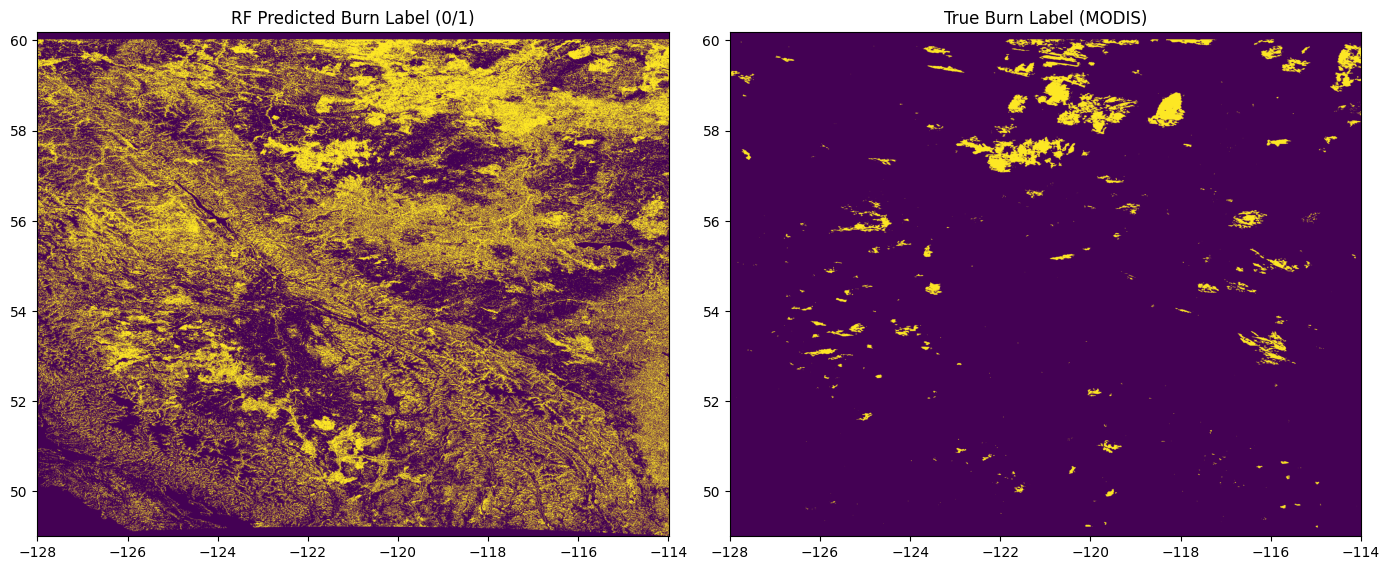

In [236]:
pred_tif = r"D:\Yadu\Data science\DSS and ARM\WF_RF_PRED_BC_2023 (1).tif"
true_tif = r"D:\Yadu\Data science\DSS and ARM\WF_TRUE_BURN_BC_2023.tif"

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

with rasterio.open(pred_tif) as src:
    show(src, ax=axes[0])
    axes[0].set_title("RF Predicted Burn Label (0/1)")

with rasterio.open(true_tif) as src:
    show(src, ax=axes[1])
    axes[1].set_title("True Burn Label (MODIS)")

plt.tight_layout()
plt.savefig("Map_Pred_vs_Truth.png", dpi=200)
plt.show()

The RF Predicted Burn Label map shows the model’s output, where yellow-colored pixels represent areas predicted as fire and dark-colored pixels represent areas predicted as no fire within the study area. The map on the right shows the True Burn Label derived from MODIS data, where yellow pixels indicate locations where fire actually occurred and dark pixels indicate areas with no fire occurrence.

In [237]:

pred_tif = r"D:\Yadu\Data science\DSS and ARM\WF_RF_PRED_BC_2023 (1).tif"
true_tif = r"D:\Yadu\Data science\DSS and ARM\WF_TRUE_BURN_BC_2023.tif"

# Opens the model-predicted fire map 
with rasterio.open(pred_tif) as psrc:
    pred = psrc.read(1)
    meta = psrc.meta.copy()

# Opens the actual fire map from MODIS
with rasterio.open(true_tif) as tsrc:
    true = tsrc.read(1)

Here we ensure that predicted and the true values are in the same format (0,1) It is essential when sometimes the prediction and actual may contain values other than 0 and 1

In [238]:
# Ensure 0/1
pred = (pred > 0).astype(np.uint8)
true = (true > 0).astype(np.uint8)

In [239]:
# Error codes:
# 0 = TN (true=0, pred=0)  # Correctly predicted no fire
# 1 = FP (true=0, pred=1)  # Fire predicted, but no fire happened
# 2 = FN (true=1, pred=0)  # Fire happened, but model missed it
# 3 = TP (true=1, pred=1)  # Fire predicted and fire happened
error = (true * 2 + pred).astype(np.uint8)  # (0..3) but FN/TP swapped? let's define explicitly below

Now impliment a pixel-wise confusion matrix by classifying each pixel as a true positive, true negative, false positive, or false negative.

In [240]:
# Explicit mapping
TN = ((true == 0) & (pred == 0))
FP = ((true == 0) & (pred == 1))
FN = ((true == 1) & (pred == 0))
TP = ((true == 1) & (pred == 1))

# creates a map that shows where the model was correct and where it made mistakes. here, we assigning the pixels instead of counting them
err_map = np.zeros_like(true, dtype=np.uint8)
err_map[FP] = 1
err_map[FN] = 2
err_map[TP] = 3
# TN stays 0

# Error Map 
* This image is created by comparing the predicted fire map with the actual fire map on a pixel-by-pixel basis. Each pixel is classified into one of four categories: True Positive (TP), where fire was correctly predicted; True Negative (TN), where no fire was correctly predicted; False Positive (FP), where fire was predicted but did not occur; and False Negative (FN), where fire occurred but was missed by the model. These categories are represented using different colors in the map, allowing a clear spatial visualization of correct predictions and model errors across the study area.

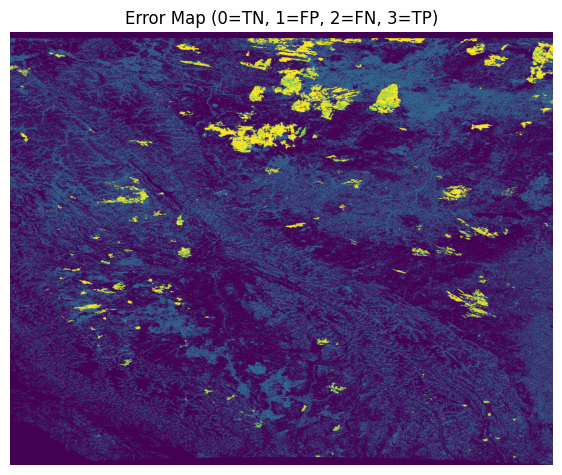

In [241]:
plt.figure(figsize=(7,6))
plt.imshow(err_map)
plt.title("Error Map (0=TN, 1=FP, 2=FN, 3=TP)")
plt.axis("off")
plt.savefig("Error_Map_TP_TN_FP_FN.png", dpi=200)
plt.show()


In [242]:
tp = TP.sum()
tn = TN.sum()
fp = FP.sum()
fn = FN.sum()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp + 1e-9)
recall = tp / (tp + fn + 1e-9)
f1 = 2 * precision * recall / (precision + recall + 1e-9)

print("Pixel-level metrics from rasters:")
print("TP:", tp, "TN:", tn, "FP:", fp, "FN:", fn)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)


Pixel-level metrics from rasters:
TP: 207630 TN: 4924063 FP: 2587383 FN: 47862
Accuracy: 0.6607099219795497
Precision: 0.07428587988678405
Recall: 0.8126673242214989
F1: 0.1361282802459962


At the pixel level, the model successfully detects most wildfire areas, as shown by the high recall of over 80%. However, it predicts fire in many locations where no fire actually occurred, resulting in a large number of false positives and very low precision. This behavior indicates that the model is conservative and tends to overestimate fire-prone regions, which is suitable for early warning systems but not for precise fire boundary detection.

In [243]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Color map: TN, FP, FN, TP
cmap = ListedColormap([
    "#2b2b2b",  # TN
    "#ff9800",  # FP
    "#e53935",  # FN
    "#43a047"   # TP
])

legend_handles = [
    mpatches.Patch(color="#2b2b2b", label="TN: True Non-burn"),
    mpatches.Patch(color="#ff9800", label="FP: False Burn (Over-prediction)"),
    mpatches.Patch(color="#e53935", label="FN: Missed Burn (Under-prediction)"),
    mpatches.Patch(color="#43a047", label="TP: True Burn"),
]


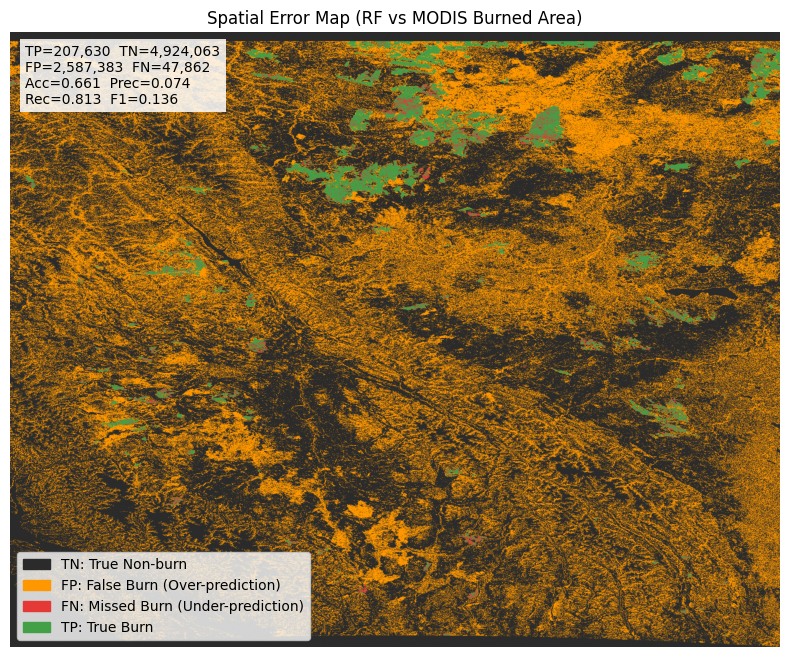

In [244]:
tp = TP.sum()
tn = TN.sum()
fp = FP.sum()
fn = FN.sum()

acc = (tp + tn) / (tp + tn + fp + fn)
prec = tp / (tp + fp + 1e-9)
rec = tp / (tp + fn + 1e-9)
f1 = 2 * prec * rec / (prec + rec + 1e-9)

text = (
    f"TP={tp:,}  TN={tn:,}\n"
    f"FP={fp:,}  FN={fn:,}\n"
    f"Acc={acc:.3f}  Prec={prec:.3f}\n"
    f"Rec={rec:.3f}  F1={f1:.3f}"
)

plt.figure(figsize=(8, 7))
plt.imshow(err_map, cmap=cmap, vmin=0, vmax=3)
plt.title("Spatial Error Map (RF vs MODIS Burned Area)")
plt.axis("off")
plt.legend(handles=legend_handles, loc="lower left", frameon=True)

# metrics box (top-left)
plt.gca().text(
    0.02, 0.98, text,
    transform=plt.gca().transAxes,
    va="top", ha="left",
    bbox=dict(facecolor="white", alpha=0.85, edgecolor="none")
)

plt.tight_layout()
plt.savefig("Error_Map_RF_with_Metrics.png", dpi=250)
plt.show()


In [245]:
# Applying Hyper Parameter tuning (Randomized CV)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42)

rf_grid = {
    "n_estimators": [200, 400, 800],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", None]
}

rf_search = GridSearchCV(
    rf,
    rf_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
rf_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)
print("Best RF CV AUC:", rf_search.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:
best_rf = rf_search.best_estimator_
rf_pred = best_rf.predict(X_test)
rf_proba = best_rf.predict_proba(X_test)[:,1]

print("Tuned Random Forest")
print("Test AUC:", roc_auc_score(y_test, rf_proba))
print(classification_report(y_test, rf_pred))


In [ ]:
xgb_model = xgb.XGBClassifier(
    eval_metric="logloss",
    random_state=42
)

xgb_dist = {
    "n_estimators": [300, 500, 800, 1200],
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.2, 0.5],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0]
}

xgb_search = RandomizedSearchCV(
    xgb_model,
    xgb_dist,
    n_iter=30,            # good enough + fast
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_search.fit(X_train, y_train)

print("Best XGB params:", xgb_search.best_params_)
print("Best XGB CV AUC:", xgb_search.best_score_)


In [ ]:
best_xgb = xgb_search.best_estimator_
xgb_pred = best_xgb.predict(X_test)
xgb_proba = best_xgb.predict_proba(X_test)[:,1]

print("Tuned XGBoost")
print("Test AUC:", roc_auc_score(y_test, xgb_proba))
print(classification_report(y_test, xgb_pred))


In [ ]:
def summarize(name, y_true, y_pred, y_proba):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_proba),
    }

summary = pd.DataFrame([
    summarize("Tuned Random Forest", y_test, rf_pred, rf_proba),
    summarize("Tuned XGBoost", y_test, xgb_pred, xgb_proba),
])

summary

In [ ]:
# Doing Hyperparameter tuning doesn't made any significant difference 